<a href="https://colab.research.google.com/github/alifele/EEG-computation/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Important Imports

In [1]:
!pip install mat4py
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mt
import os
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import combinations
from numpy.fft import fft
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
from numpy.fft import fft
from sklearn.metrics import classification_report

# Loading Data

In [9]:
!git clone https://github.com/alifele/EEG-computation.git
%cd EEG-computation

Cloning into 'EEG-computation'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 540 (delta 10), reused 0 (delta 0), pack-reused 522
Receiving objects: 100% (540/540), 709.37 MiB | 62.58 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (419/419), done.
/content/EEG-computation/EEG-computation/EEG-computation/EEG-computation/EEG-computation


In [0]:
disorder_dic = []
directory = os.fsencode('EEG Data/disorder')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/disorder/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])
    j = j+1
        
normal_dic = []
directory = os.fsencode('EEG Data/normal')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    normal_dic.append(np.array(mt.loadmat('EEG Data/normal/{}'.format(filename))[filename.split('.')[0]]))
    
channels_normal = [ [] for i in range(len(normal_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_normal:
    for i in range(19):
        person.append(normal_dic[j][:,i])
    j = j+1   
        
data = {"N":channels_normal,
      "D":channels_disorder}


# Loading Validation Data

In [0]:
disorder_dic = []
directory = os.fsencode('EEG Data/New_Shuffled_Validation(disorder_normal)')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/New_Shuffled_Validation(disorder_normal)/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])
    j = j+1
        
DATA_ = channels_disorder

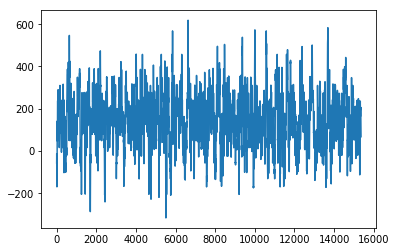

In [12]:
plt.plot(DATA_[4][5])

# Generating New Data

In [0]:
def New_Data_Generator_N():
    number_of_samples = 45
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['N'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['N'].append(new_data[person])
        person += 1

    
def New_Data_Generator_D():
    number_of_samples = 45
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['D'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['D'].append(new_data[person])
        person += 1


In [0]:
New_Data_Generator_N()
New_Data_Generator_D()

In [15]:
n_D , n_N = len(data['D']), len(data['N'])

print('The number of Disorders is:{} and the number of Normals is:{}'.format(n_D, n_N))

The number of Disorders is:1186 and the number of Normals is:1122


# Generating The FT Data set

In [0]:
def Clear_FDomain():
  index = np.arange(0,512*30)
  f = np.linspace(0,512,512*30)
  f_max = f[len(f[f<120])]
  ind_min = 2
  ind_max = list(index[f==f_max])[0]
  f_min = f[ind_min]

  print('The f_min is {}\nThe f_max is {}\nThe ind_min is {} \nAnd the ind_max is {}'.format(f_min, f_max, ind_min, ind_max))


  sam_FT = np.abs(np.fft.fft(data['D'][50][7]))

  # The 50 Htz noise elimination information

  f_45 = f>45
  f_55 = f<55
  f_bar = f<45

  for i in range(f.shape[0]):
    f_bar[i] = f_45[i] and f_55[i]


  noise = f[sam_FT == np.max(sam_FT[f_bar])][0]
  noise_index = list(index[f==noise])[0] # in range 0, 512*30
  del_domain = 40
  del_range = [noise_index + i for i in range(-del_domain,del_domain)]
  print('The Frequency of noise is:{} and the index of the noise is:{}'.format(noise, noise_index))

  
  plt.figure()
  plt.plot(f_bar)
  f = np.linspace(0,512,512*30)[ind_min:ind_max]
  
  
  normal = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_N)]
  disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_D)]


  FT = {'D':disorder,
       'N':normal}

  from numpy.fft import fft

  for d in range(n_D):
      for i in range(19):

          FT['D'][d][i] = np.abs(fft(data['D'][d][i]))[ind_min:ind_max]
          FT['D'][d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
          FT['D'][d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])

  for n in range(n_N):
      for i in range(19):
          FT['N'][n][i] = np.abs(fft(data['N'][n][i]))[ind_min:ind_max]
          FT['N'][n][i][noise_index-del_domain - ind_min: noise_index+del_domain -ind_min] = np.average(FT['N'][n][i][noise_index-del_domain - ind_min-120: noise_index+del_domain -ind_min-120])
          FT['N'][n][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average( FT['N'][n][i][2*noise_index-del_domain - ind_min-120 : 2*noise_index+del_domain - ind_min-120])


  FT['N'] = np.array(FT['N'])
  FT['D'] = np.array(FT['D'])
  plt.figure()
  plt.plot(f, FT['N'][56][8])
  
  
  

  FT_matrix_N = FT['N']
  FT_matrix_D = FT['D']

  temp_D = FT_matrix_D.reshape((FT_matrix_D.shape[0],FT_matrix_D.shape[2],FT_matrix_D.shape[1]))
  temp_N = FT_matrix_N.reshape((FT_matrix_N.shape[0],FT_matrix_N.shape[2],FT_matrix_N.shape[1]))
  #or d in range(FT_matrix.shape[0]):
  scaler = StandardScaler()

  for n in range(FT_matrix_N.shape[0]):
    temp_N[n]= scaler.fit_transform(FT_matrix_N[n].T)
  
  for d in range(FT_matrix_D.shape[0]):
    temp_D[d]= scaler.fit_transform(FT_matrix_D[d].T)

    
  for n in range(FT_matrix_N.shape[0]):
    FT_matrix_N[n]= temp_N[n].T
  
  for d in range(FT_matrix_D.shape[0]):
    FT_matrix_D[d]= temp_D[d].T
    
    
  plt.figure()
  plt.plot(f,FT_matrix_D[56,8])
  FT_matrix_D.shape, FT_matrix_N.shape
  
  Data = np.vstack((FT_matrix_N, FT_matrix_D))
  target = np.hstack((np.ones(FT_matrix_N.shape[0]), np.zeros(FT_matrix_D.shape[0])))
  
  Data, target = shuffle(Data, target)

  return Data, target


In [0]:
def Clear_FDomain_():
  index = np.arange(0,512*30)
  f = np.linspace(0,512,512*30)
  f_max = f[len(f[f<120])]
  ind_min = 2
  ind_max = list(index[f==f_max])[0]
  f_min = f[ind_min]

  print('The f_min is {}\nThe f_max is {}\nThe ind_min is {} \nAnd the ind_max is {}'.format(f_min, f_max, ind_min, ind_max))


  sam_FT = np.abs(np.fft.fft(DATA_[6][7]))

  # The 50 Htz noise elimination information

  f_45 = f>45
  f_55 = f<55
  f_bar = f<45

  for i in range(f.shape[0]):
    f_bar[i] = f_45[i] and f_55[i]


  noise = f[sam_FT == np.max(sam_FT[f_bar])][0]
  noise_index = list(index[f==noise])[0] # in range 0, 512*30
  del_domain = 40
  del_range = [noise_index + i for i in range(-del_domain,del_domain)]
  print('The Frequency of noise is:{} and the index of the noise is:{}'.format(noise, noise_index))

  
  plt.figure()
  plt.plot(f_bar)
  f = np.linspace(0,512,512*30)[ind_min:ind_max]
  
  
  disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(72)]


  FT_ = disorder

  from numpy.fft import fft

  for d in range(72):
      for i in range(19):

          FT_[d][i] = np.abs(fft(DATA_[d][i]))[ind_min:ind_max]
          FT_[d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT_[d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
          FT_[d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT_[d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])

          
  FT_= np.array(FT_)
  plt.figure()
  plt.plot(f, FT_[56][8])
  
  
  


  FT_matrix_D = FT_

  temp_D = FT_matrix_D.reshape((FT_matrix_D.shape[0],FT_matrix_D.shape[2],FT_matrix_D.shape[1]))
  
  #or d in range(FT_matrix.shape[0]):
  scaler = StandardScaler()

  
  
  for d in range(FT_matrix_D.shape[0]):
    temp_D[d]= scaler.fit_transform(FT_matrix_D[d].T)


  
  for d in range(FT_matrix_D.shape[0]):
    FT_matrix_D[d]= temp_D[d].T
    
    
  plt.figure()
  plt.plot(f,FT_matrix_D[56,8])
  FT_matrix_D.shape, 
  
  Data = FT_matrix_D
  

  return Data

The f_min is 0.06667100722703301
The f_max is 120.00781300865941
The ind_min is 2 
And the ind_max is 3600
The Frequency of noise is:50.003255420274755 and the index of the noise is:1500
The f_min is 0.06667100722703301
The f_max is 120.00781300865941
The ind_min is 2 
And the ind_max is 3600
The Frequency of noise is:50.103261931115306 and the index of the noise is:1503


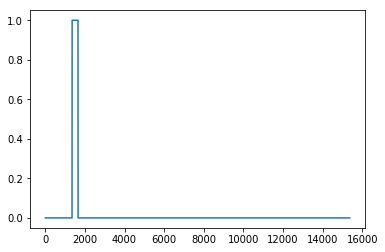

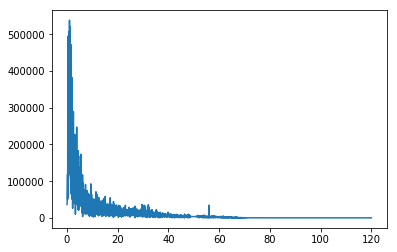

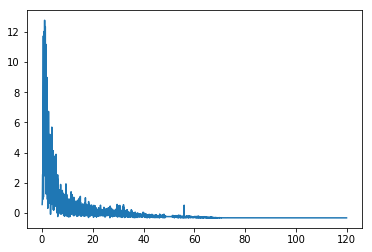

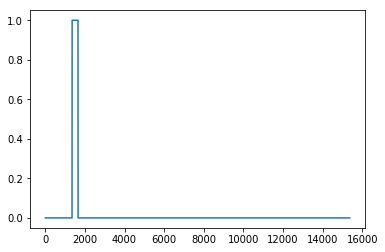

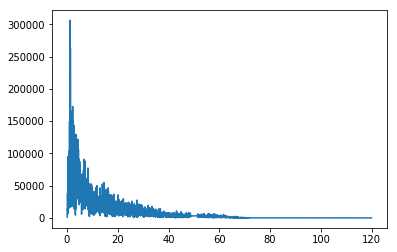

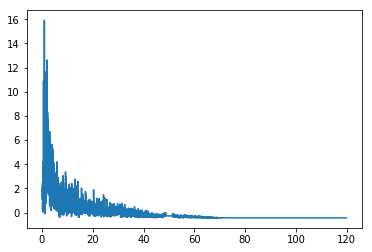

In [18]:
F_DATA_ = Clear_FDomain_()
F_Data, target = Clear_FDomain()

(68362, 1)

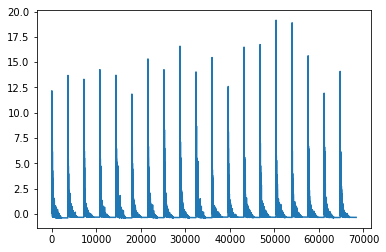

In [19]:
plt.plot(F_DATA_[2].reshape(-1,1))
F_DATA_[2].reshape(-1,1).shape

(68362, 1)

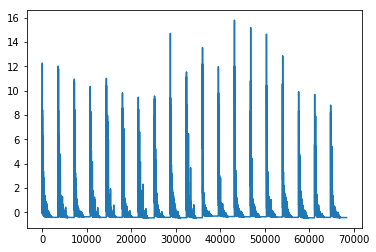

In [20]:
plt.plot(F_Data[2].reshape(-1,1))
F_Data[2].reshape(-1,1).shape

# Generating the Time Sequence dataset

In [0]:
def Clear_TDomain():
  
  T_D = np.array(data['D'])
  T_N = np.array(data['N'])
  temp_D = T_D.reshape((T_D.shape[0],T_D.shape[2],T_D.shape[1]))
  temp_N = T_N.reshape((T_N.shape[0],T_N.shape[2],T_N.shape[1]))
  scaler = StandardScaler()

  for n in range(T_N.shape[0]):
      temp_N[n]= scaler.fit_transform(T_N[n].T)

  for d in range(T_D.shape[0]):
    temp_D[d]= scaler.fit_transform(T_D[d].T)


  for n in range(T_N.shape[0]):
    T_N[n]= temp_N[n].T

  for d in range(T_D.shape[0]):
    T_D[d]= temp_D[d].T

  plt.plot(T_D[3][5])
  
  Data = np.vstack((T_N, T_D))
  target = np.hstack((np.ones(T_N.shape[0]), np.zeros(T_D.shape[0])))
  
  Data, target = shuffle(Data, target)
  
  return Data, target

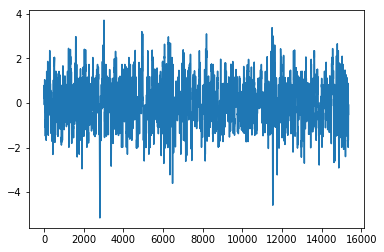

In [22]:
T_Data, T_target = Clear_TDomain()

In [0]:
def Clear_TDomain_():
  
  T_D = np.array(DATA_)

  temp_D = T_D.reshape((T_D.shape[0],T_D.shape[2],T_D.shape[1]))
  scaler = StandardScaler()


  for d in range(T_D.shape[0]):
    temp_D[d]= scaler.fit_transform(T_D[d].T)


  for d in range(T_D.shape[0]):
    T_D[d]= temp_D[d].T

  plt.plot(T_D[3][5])
  
  Data = T_D

  
  return Data

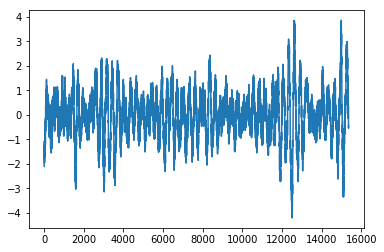

In [24]:
T_DATA_  = Clear_TDomain_()

#PCA

In [25]:
pca = PCA(n_components = 0.95)
pca.fit(F_Data.reshape(F_Data.shape[0],-1))
F_pca = pca.transform(F_Data.reshape(F_Data.shape[0],-1))
F_pca.shape


F_pca_ = pca.transform(F_DATA_.reshape(F_DATA_.shape[0],-1))
F_pca_.shape

(72, 1114)

# KNN for the FT Data set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(F_pca, target, random_state=42)
X  = F_pca_

#del F_pca

from sklearn.neighbors import KNeighborsClassifier


y_pred_list_knn = []
y_pred_knn=0
for i in range(30):
  
  rand = int(np.random.random()*40)+1
  #print('rand = {}'.format(rand))
  knn = KNeighborsClassifier(n_neighbors = rand)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  y_pred_knn += knn.predict(X)
  
  y_pred_list_knn.append(y_pred)
  print('the progress is {}%'.format(int((i+1)/30 * 100)))



yy  = np.array(y_pred_list_knn)
shape=yy.shape[0]

a=0
for i in range(shape):

  a +=yy[i]


a[a/shape<=0.5]=0
a[a/shape>0.5]=1

y_pred_knn[y_pred_knn/shape<=0.5]=0
y_pred_knn[y_pred_knn/shape>0.5]=1
y_knn = y_pred
print(classification_report(a,y_test))
print(a)


the progress is 3%
the progress is 6%
the progress is 10%
the progress is 13%
the progress is 16%
the progress is 20%
the progress is 23%
the progress is 26%
the progress is 30%
the progress is 33%
the progress is 36%
the progress is 40%
the progress is 43%
the progress is 46%
the progress is 50%
the progress is 53%
the progress is 56%
the progress is 60%
the progress is 63%
the progress is 66%
the progress is 70%
the progress is 73%
the progress is 76%
the progress is 80%
the progress is 83%
the progress is 86%
the progress is 90%
the progress is 93%
the progress is 96%
the progress is 100%
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       292
         1.0       0.98      0.97      0.98       285

    accuracy                           0.98       577
   macro avg       0.98      0.98      0.98       577
weighted avg       0.98      0.98      0.98       577

[0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 

In [27]:
y_pred_knn

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 1.])

# Decision Tree

In [28]:
#X_train, X_test, y_train, y_test = train_test_split(F_pca, F_target)
#X = F_pca_


from sklearn.tree import DecisionTreeClassifier




y_pred_list_tree = []
y_pred_tree=0
for i in range(20):
  
  rand = int(np.random.random()*30)+6
  #print('rand = {}'.format(rand))
  tree_list = []
  tree = DecisionTreeClassifier(max_depth=rand)

  tree.fit(X_train, y_train)
  y_pred = tree.predict(X_test)
  
  y_pred_tree += tree.predict(X)
  
  y_pred_list_tree.append(y_pred)

  print('the progress is {}%'.format(int((i+1)/20 * 100)))


yy  = np.array(y_pred_list_tree)
shape=yy.shape[0]

a=0
for i in range(shape):

  a +=yy[i]


a[a/shape<=0.5]=0
a[a/shape>0.5]=1

y_pred_tree[y_pred_tree/shape<=0.5]=0
y_pred_tree[y_pred_tree/shape>0.5]=1
y_tree = y_pred
print(a)
print(classification_report(a,y_test))

the progress is 5%
the progress is 10%
the progress is 15%
the progress is 20%
the progress is 25%
the progress is 30%
the progress is 35%
the progress is 40%
the progress is 45%
the progress is 50%
the progress is 55%
the progress is 60%
the progress is 65%
the progress is 70%
the progress is 75%
the progress is 80%
the progress is 85%
the progress is 90%
the progress is 95%
the progress is 100%
[0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 

In [29]:
F_pca_.shape

(72, 1114)

# Random Forest

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(F_pca, F_target)
#X = F_pca_


from sklearn.ensemble import RandomForestClassifier
y_pred_list_rand_tree = []
y_pred_randtree=0
y_pred=0
for i in range(20):
  
  
  rand = int(np.random.normal(2000,200))
  #print('rand = {}'.format(rand))

  rand_tree = RandomForestClassifier(n_estimators=rand, max_depth=15, n_jobs=-1)

  rand_tree.fit(X_train, y_train)
  
  y_pred += rand_tree.predict(X_test)
  y_pred_randtree += rand_tree.predict(X)
  
  y_pred_list_rand_tree.append(y_pred)
  print('the progress is {}%'.format(int((i+1)/20 * 100)))


shape=yy.shape[0]






y_pred[y_pred/shape<=0.5]=0
y_pred[y_pred/shape>0.5]=1

y_rand_tree = y_pred

y_pred_randtree[y_pred_randtree/shape<=0.5]=0
y_pred_randtree[y_pred_randtree/shape>0.5]=1

print(a)
print(classification_report(a,y_test))

the progress is 5%
the progress is 10%
the progress is 15%
the progress is 20%
the progress is 25%
the progress is 30%
the progress is 35%
the progress is 40%
the progress is 45%
the progress is 50%
the progress is 55%
the progress is 60%
the progress is 65%
the progress is 70%
the progress is 75%
the progress is 80%
the progress is 85%
the progress is 90%
the progress is 95%
the progress is 100%
[0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 

# RNN

In [31]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM


Using TensorFlow backend.


In [32]:
T_DATA_.shape, 

((72, 19, 15360),)

In [0]:
T_Data = T_Data.reshape(T_Data.shape[0],T_Data.shape[2], T_Data.shape[1])
X = T_DATA_.reshape(T_DATA_.shape[0],T_DATA_.shape[1], T_DATA_.shape[2])
X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(T_Data, T_target, random_state=42)


In [37]:
X_train_T.shape, X.shape
#Note that the Shape of the Data must be in form of (898, 19, 15360)
#If it is not in the mentioned shape please rerun the above cell

((1731, 19, 15360), (72, 19, 15360))

In [0]:

model = Sequential()
model.add(LSTM(25,return_sequences=False, input_shape=(X_train_T.shape[1], X_train_T.shape[2])))
model.add(Dropout(0.5))
#model.add(LSTM(100)) dramatically worse results
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train_T, y_train_T, batch_size=128, epochs=10, validation_data=(X_test_T, y_test_T), verbose=1)

y_pred =np.array(model.predict_classes(X_test_T)).reshape(-1)

y_rnn = y_pred

y_pred_rnn = np.array(model.predict_classes(X)).reshape(-1)
print(classification_report(y_pred, y_test_T))
print(y_pred)

Train on 1731 samples, validate on 577 samples
Epoch 1/10


# SVC

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(F_pca, F_target)
X = F_pca_

from sklearn import svm
svm_model= svm.SVC(kernel='linear')
# runnig this algorithm with ariginal data takes very very long time
# so for this regressoin i am going to use 'PCA'ed data
svm_model.fit(X_train, y_train)
score = svm_model.score(X_test, y_test)
print("the score of the SVC is: {} ".format(score))
y_pred_linear = svm_model.predict(X_test)
y_pred_linear_svc = svm_model.predict(X)


from sklearn import svm
svm_model= svm.SVC(kernel='poly')
# runnig this algorithm with ariginal data takes very very long time
# so for this regressoin i am going to use 'PCA'ed data
svm_model.fit(X_train, y_train)
score = svm_model.score(X_test, y_test)
print("the score of the SVC is: {} ".format(score))
y_pred_poly = svm_model.predict(X_test)
y_pred_poly_svc = svm_model.predict(X)

pred = (y_pred_poly+y_pred_linear)/2
y_pred_svc = (y_pred_poly_svc+y_pred_linear_svc)/2

pred[pred<0.5]=0
pred[pred>=0.5]=1

y_svc = pred

y_pred_svc[y_pred_svc<0.5]=0
y_pred_svc[y_pred_svc>=0.5]=1

print(pred)
print(classification_report(pred, y_test ))

## Estimators

In [0]:
print(y_pred_knn)



In [0]:
print(y_pred_tree)


In [0]:
print(y_pred_randtree)


In [0]:
print(y_pred_rnn)


In [0]:
print(y_pred_svc)

In [0]:
final_pred = (2*y_pred_knn +y_pred_tree  +y_pred_randtree+2*y_pred_rnn+y_pred_svc)/7

final_pred[final_pred<=0.5]=0
final_pred[final_pred>0.5]=1
print(final_pred)

In [0]:
y_final = (2*y_knn + y_tree + y_rand_tree + 2*y_rnn + y_svc )/7
y_final[y_final<=0.5]=0
y_final[y_final>0.5]=1
print(classification_report(y_final, y_test))

In [0]:
y_final